# Importing python libraries

In [1]:
## Import necessary libraries for interpolation and visualization
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path
from dotenv import load_dotenv
load_dotenv(override=True)

## Import definitions
from surfPlot_def import visualize_data, read_header, load_afm_data, center_on_minimum

# Defining parameters and Getting data from MI database

In [2]:
# Define parameters
radius = 3  # Radius of the disk (in µm)
numXpoints = 200  # Resolution in X direction
numYpoints = 200  # Resolution in Y direction

#Creaate MIOutput directory if it does not exist
output_dir = Path("MIOutput")
output_dir.mkdir(parents=True, exist_ok=True)

# Define manually paths to the data file
CPFEM_file_path = "C:\\github\\ICME-OoCTO\\CP_indentation\\MIOutput\\CPFEM_SurfTopo.txt"
CPFEM_file_path = "C:\\github\\ICME-OoCTO\\CP_indentation\\MIOutput\\Displacement2.txt"
AFM_file_path = "C:\\github\\ICME-OoCTO\\CP_indentation\\MIOutput\\AFM_SurfTopo.txt"

## Plot surface output data from numerical simulations (CP-FEM)

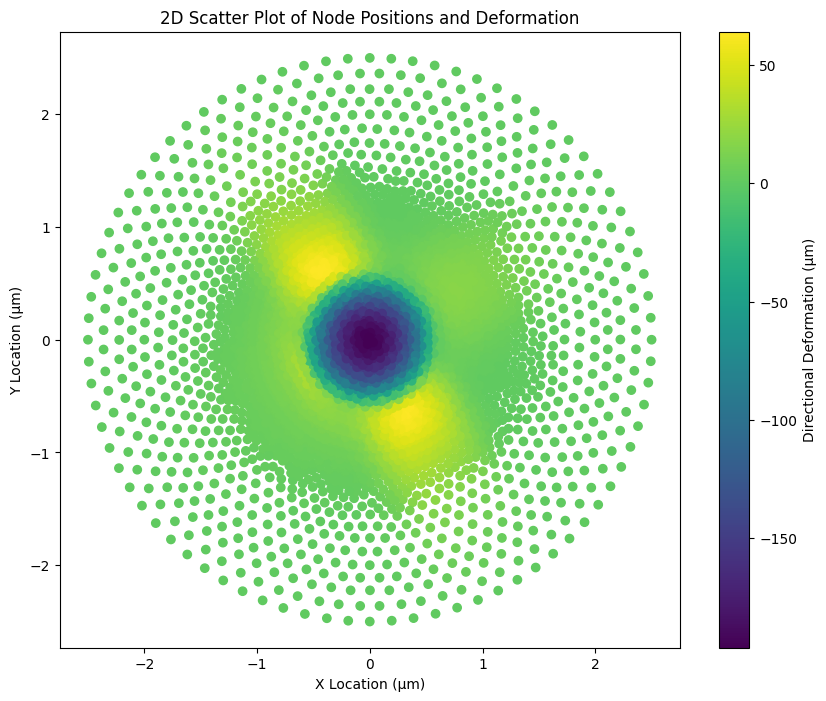

In [3]:
# Step 1: Read the data from the file
x_data, y_data, z_data, deformation_data = [], [], [], []

try:
    with open(CPFEM_file_path, 'r') as file:
        for i, line in enumerate(file):
            # Skip the header line
            if i == 0:
                continue
            try:
                # Split the line into columns
                columns = line.strip().split()
                # Extract X, Y, Z positions and deformation values
                x = float(columns[1].replace(',', '.'))
                y = float(columns[2].replace(',', '.'))
                z = float(columns[3].replace(',', '.'))
                deformation = float(columns[4].replace(',', '.'))
                x_data.append(x)
                y_data.append(y)
                z_data.append(z)
                deformation_data.append(deformation)
            except (ValueError, IndexError):
                print(f"Skipping invalid line: {line.strip()}")
except FileNotFoundError:
    print(f"File '{CPFEM_file_path}' not found.")
    raise SystemExit("File not found. Please check the file path.")

# Step 2: Convert lists to numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)
z_data = np.array(z_data)
deformation_data = np.array(deformation_data) * 1e3 # Convert to micrometers

# Step 3: Visualize the data in a 2D scatter plot
fig = plt.figure(figsize=(10, 8))
plt.scatter(x_data, y_data, c=deformation_data, cmap='viridis')

plt.title("2D Scatter Plot of Node Positions and Deformation")
plt.xlabel("X Location (μm)")
plt.ylabel("Y Location (μm)")
plt.colorbar(label="Directional Deformation (μm)")
plt.axis('equal')  # Ensure equal scaling for X and Y axes
plt.show()

## Plot surface output data from experiment (AFM)

Header lines: ['# Channel: Detail 2', '# Width: 6.99 Âµm', '# Height: 7.07 Âµm', '# Value units: m']


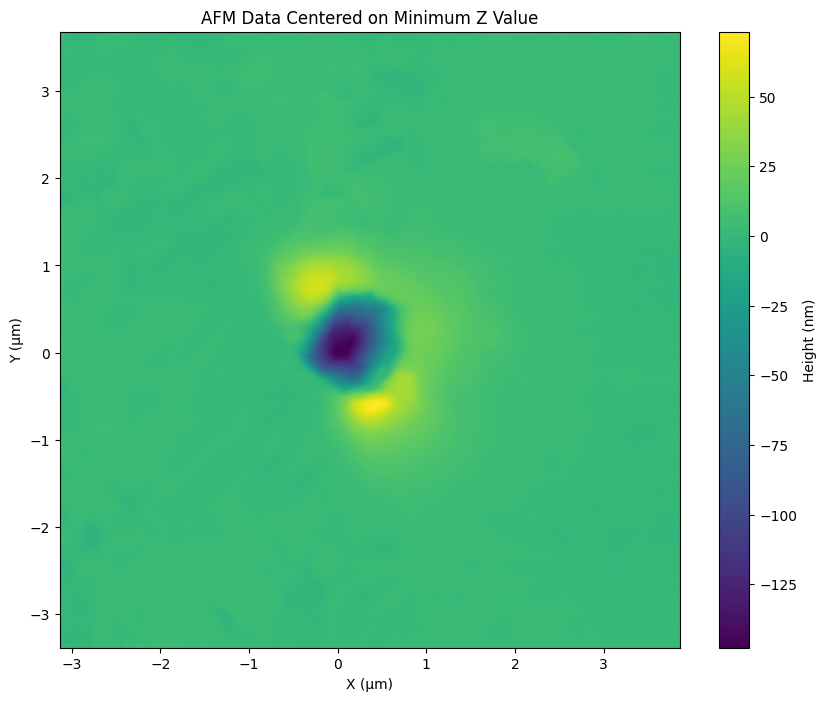

In [4]:
# Step 1: Read and parse header
header_lines = read_header(AFM_file_path)
print("Header lines:", header_lines)
header = {} 
for line in header_lines:
    if "Channel" in line: header["Channel"] = line.split(":")[1].strip()
    elif "Width" in line: header["Width"] = float(line.split(":")[1].strip().split()[0].replace("µm", ""))
    elif "Height" in line: header["Height"] = float(line.split(":")[1].strip().split()[0].replace("µm", ""))
    elif "Value units" in line: header["Value units"] = line.split(":")[1].strip()

# Step 2: Load AFM data
data = load_afm_data(AFM_file_path)

# Convert height values to nanometers
data = data * 1e9  # Convert from meters to nanometers

grid_x = np.linspace(0, header["Width"], data.shape[1])
grid_y = np.linspace(0, header["Height"], data.shape[0])
grid_x, grid_y = np.meshgrid(grid_x, grid_y) # Create a meshgrid for X and Y coordinates

# Step 3: Center data on minimum Z value
grid_x_centered, grid_y_centered = center_on_minimum(data, grid_x, grid_y)

# Step 4 : Smooth the data using a Gaussian filter
from scipy.ndimage import gaussian_filter
data = gaussian_filter(data, sigma=1)

# Step 4: Visualize the centered data
visualize_data(data, grid_x_centered, grid_y_centered)

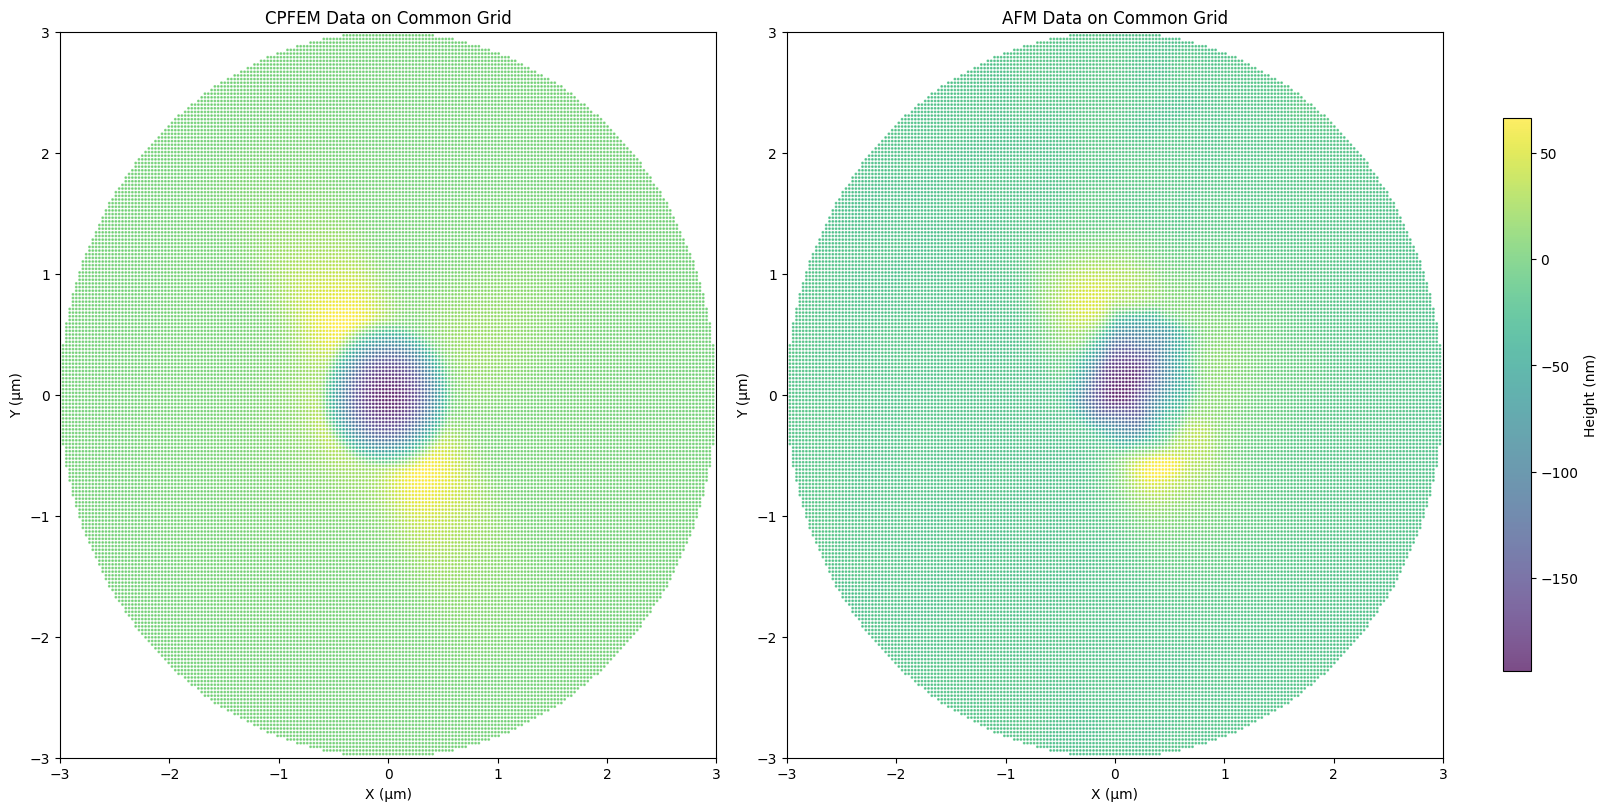

In [5]:
# Step 1: Generate a common grid
grid_x, grid_y = np.meshgrid(
    np.linspace(-radius, radius, numXpoints),
    np.linspace(-radius, radius, numYpoints)
)
circle_mask = grid_x**2 + grid_y**2 <= radius**2  # Create a circular mask

# Step 2: Interpolate CPFEM data onto the common grid
cpfem_points = np.column_stack((x_data, y_data))  # CPFEM X, Y positions
cpfem_values = deformation_data  # CPFEM deformation values
cpfem_grid_z = griddata(
    cpfem_points, cpfem_values, (grid_x, grid_y), method='cubic', fill_value=np.nan
)
cpfem_grid_z = np.where(circle_mask, cpfem_grid_z, np.nan)  # Apply circular mask

# Step 3: Interpolate AFM data onto the common grid
afm_points = np.column_stack((grid_x_centered.flatten(), grid_y_centered.flatten()))  # AFM X, Y positions
afm_values = data.flatten()  # AFM height values
afm_grid_z = griddata(
    afm_points, afm_values, (grid_x, grid_y), method='linear', fill_value=np.nan
)
afm_grid_z = np.where(circle_mask, afm_grid_z, np.nan)  # Apply circular mask

# Step 4: Extend the CPFEM and AFM grids to match a disk using external values
cpfem_grid_z = np.nan_to_num(cpfem_grid_z, nan=np.nanmean(cpfem_grid_z))  # Replace NaNs with mean
afm_grid_z = np.nan_to_num(afm_grid_z, nan=np.nanmean(afm_grid_z))  # Replace NaNs with mean

# Step 5: Shift the CPFEM grid to match the AFM grid (in Z direction)
cpfem_grid_z = cpfem_grid_z - np.nanmean(cpfem_grid_z) + np.nanmean(afm_grid_z) 

# Step 5: Visualize CPFEM and AFM data side by side with the same colorbar
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# CPFEM Data
cpfem_plot = axs[0].scatter(
    grid_x[circle_mask], grid_y[circle_mask], c=cpfem_grid_z[circle_mask],
    cmap='viridis', s=1, alpha=0.7
)
axs[0].set_title("CPFEM Data on Common Grid")
axs[0].set_xlabel("X (µm)")
axs[0].set_ylabel("Y (µm)")
axs[0].set_xlim(-radius, radius)
axs[0].set_ylim(-radius, radius)

# AFM Data
afm_plot = axs[1].scatter(
    grid_x[circle_mask], grid_y[circle_mask], c=afm_grid_z[circle_mask],
    cmap='viridis', s=1, alpha=0.7
)
axs[1].set_title("AFM Data on Common Grid")
axs[1].set_xlabel("X (µm)")
axs[1].set_ylabel("Y (µm)")
axs[1].set_xlim(-radius, radius)
axs[1].set_ylim(-radius, radius)

# Add a single colorbar for both plots
cbar = fig.colorbar(cpfem_plot, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Height (nm)")

plt.show()

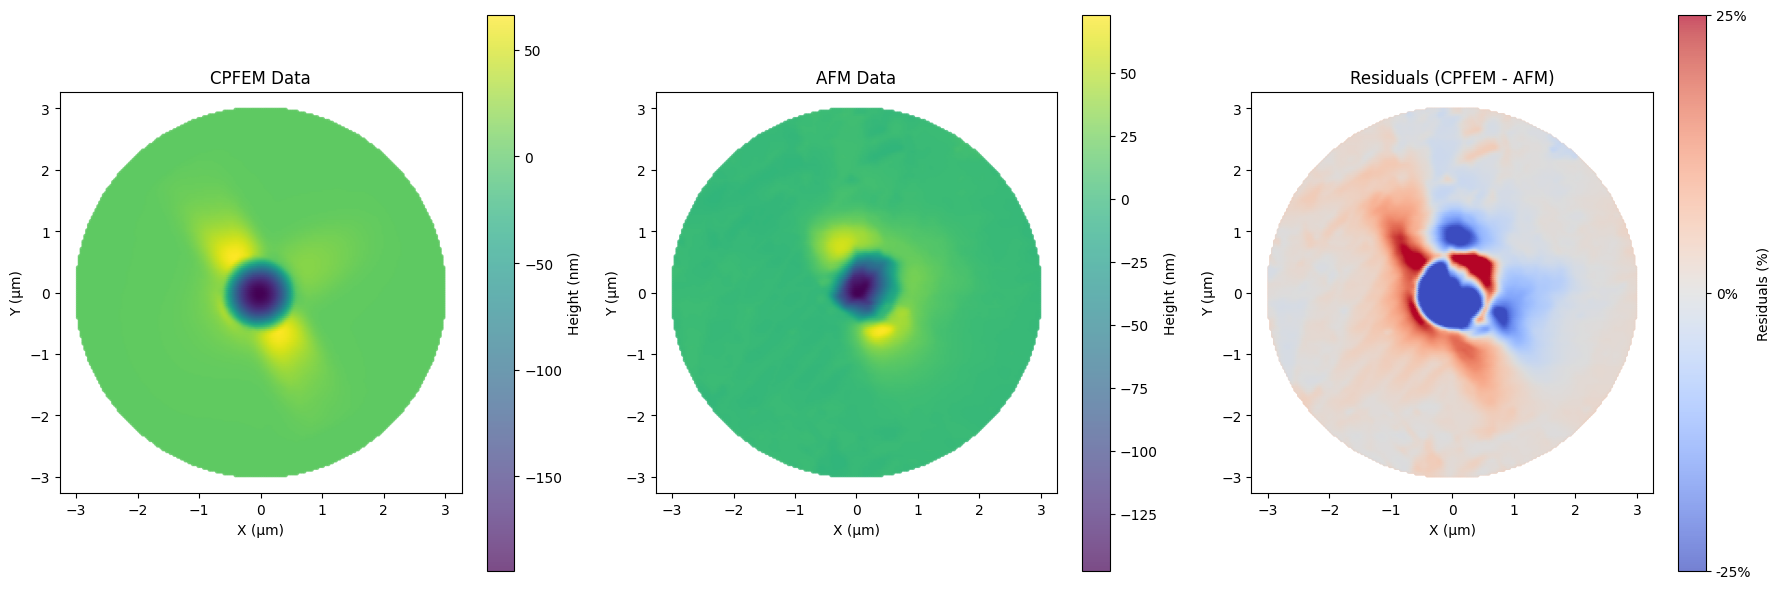

In [6]:
# Define the circular mask
def create_circular_mask(grid_x, grid_y, center, radius):
    """Creates a circular mask for the given grid."""
    dist_from_center = np.sqrt((grid_x - center[0])**2 + (grid_y - center[1])**2)
    return dist_from_center <= radius

# Define center
center = (0, 0)  # Center of the circle (e.g., origin)

# Create and apply the circular mask
circle_mask = create_circular_mask(grid_x, grid_y, center, radius)
grid_x = grid_x[circle_mask]
grid_y = grid_y[circle_mask]
cpfem_grid_z = cpfem_grid_z[circle_mask]
afm_grid_z = afm_grid_z[circle_mask]

# Function to compare CPFEM and AFM data
def plot_comparison(cpfem_data, afm_data, grid_x, grid_y):
    """Plots CPFEM and AFM data side by side and calculates residuals."""
    # Ensure grids are comparable
    assert cpfem_data.shape == afm_data.shape, "CPFEM and AFM data grids must have the same shape."
    assert grid_x.shape == grid_y.shape, "Grid X and Y must have the same shape."
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # CPFEM Data
    cpfem_plot = axs[0].scatter(
        grid_x, grid_y, c=cpfem_data, cmap='viridis', s=5, alpha=0.7
    )
    axs[0].set_title("CPFEM Data")
    axs[0].set_xlabel("X (µm)")
    axs[0].set_ylabel("Y (µm)")
    axs[0].set_aspect('equal')  # Ensure aspect ratio is 1
    fig.colorbar(cpfem_plot, ax=axs[0], label="Height (nm)")
    
    # AFM Data
    afm_plot = axs[1].scatter(
        grid_x, grid_y, c=afm_data, cmap='viridis', s=5, alpha=0.7
    )
    axs[1].set_title("AFM Data")
    axs[1].set_xlabel("X (µm)")
    axs[1].set_ylabel("Y (µm)")
    axs[1].set_aspect('equal')  # Ensure aspect ratio is 1
    fig.colorbar(afm_plot, ax=axs[1], label="Height (nm)")

    # Residuals in % only on the mask area
    #residuals = cpfem_data[circle_mask] - afm_data[circle_mask]  # Apply mask to data
    residuals = cpfem_data - afm_data
    residuals = residuals / np.nanmax(np.abs(residuals))  # Normalize residuals within the mask
    residuals_plot = axs[2].scatter(
        grid_x, grid_y, c=residuals, cmap='coolwarm', s=5, alpha=0.7
    )
    axs[2].set_title("Residuals (CPFEM - AFM)")
    axs[2].set_xlabel("X (µm)")
    axs[2].set_ylabel("Y (µm)")
    axs[2].set_aspect('equal')  # Ensure aspect ratio is 1
    # Center at 0 the colorbar and restrict range to -25% to 25%
    residuals_plot = axs[2].scatter(
        grid_x, grid_y, c=residuals, cmap='coolwarm', s=5, alpha=0.7, vmin=-0.25, vmax=0.25
    )
    cbar = fig.colorbar(residuals_plot, ax=axs[2], label="Residuals (%)")
    cbar.set_ticks([-0.25, 0, 0.25])
    cbar.set_ticklabels(["-25%", "0%", "25%"])
    
    plt.tight_layout()
    plt.show()

# Compare CPFEM and AFM data
plot_comparison(cpfem_grid_z, afm_grid_z, grid_x, grid_y)